# Performance tests

This notebook makes some time measurements of climate toolbox operations.

Import some necessary libraries.

In [1]:
import xarray as xr
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space
from esa_climate_toolbox.core import find_data_store, get_store, list_datasets
%matplotlib inline
import matplotlib.pyplot as plt

<frozen abc>:106: FutureWarning: xarray subclass VectorDataCube should explicitly define __slots__


Select a suitable dataset of global extent for the tests.

In [2]:
dsname = "esacci.LST.yr.L3C.LST.multi-sensor.multi-platform.SSMI_SSMIS.v2-33.ASC"

Find the store that contains the dataset.

In [3]:
store_name, store = find_data_store(ds_id=dsname)

Check the accepted parameters for opening this dataset.

In [4]:
store.get_open_data_params_schema(dsname)

Open a dataset for the full global extent and the year 2020, containing the variables `lst` and `lst_uncertainty`.

In [5]:
ds = store.open_data(
    dsname,
    variable_names=["lst", "lst_uncertainty"],
    time_range=["2020-01-01", "2020-12-31"],
    bbox=[-180, -90, 180, 90]
)

Show the dataset’s metadata.

In [6]:
ds

<xarray.Dataset> Size: 17MB
Dimensions:          (lat: 720, lon: 1440, time: 1, bnds: 2)
Coordinates:
  * lat              (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon              (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time             (time) datetime64[ns] 8B 2020-07-02
    time_bnds        (time, bnds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    lst              (time, lat, lon) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lst_uncertainty  (time, lat, lon) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.LST.yr.L3C.LST.multi-sensor.multi-platfor...
    date_created:            2025-03-26T17:27:59.946056
    processing_level:        L3C
    time_coverage_start:     2020-01-01T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P366DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

For demonstration and testing purposes, resample the dataset to a higher resolution, corresponding to a cell size of slightly under 10 × 10 km at the equator. (Longitudinal resolution increases with increasing latitude.)

In [7]:
source_gm = GridMapping.from_dataset(ds)

In [8]:
target_gm = source_gm.scale(3)

In [9]:
ds_resampled = resample_in_space(ds, source_gm=source_gm, target_gm=target_gm)

In [10]:
ds_resampled

<xarray.Dataset> Size: 149MB
Dimensions:          (time: 1, lat: 2160, lon: 4320, bnds: 2)
Coordinates:
  * time             (time) datetime64[ns] 8B 2020-07-02
    time_bnds        (time, bnds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
  * lon              (lon) float64 35kB -180.0 -179.9 -179.8 ... 179.9 180.0
  * lat              (lat) float64 17kB -89.96 -89.88 -89.79 ... 89.87 89.96
Dimensions without coordinates: bnds
Data variables:
    lst              (time, lat, lon) float64 75MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    lst_uncertainty  (time, lat, lon) float64 75MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.LST.yr.L3C.LST.multi-sensor.multi-platfor...
    date_created:            2025-03-26T17:27:59.946056
    processing_level:        L3C
    time_coverage_start:     2020-01-01T00:00:00
    time_coverage_end:       2021-01-01T00:00:00
    time_coverage_duration:  P366DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

Write the dataset to a Zarr archive in local storage, in the same directory as this notebook.

In [11]:
zarr_path = "lst-global-10km.zarr"
ds_resampled.to_zarr(zarr_path, mode="w")

Measure and display the time required to ingest the data from Zarr into an xarray dataset.

In [12]:
%%time
ds_zarr = xr.open_zarr(zarr_path)

CPU times: user 17.5 ms, sys: 113 μs, total: 17.6 ms
Wall time: 15.9 ms


Measure and display the time required to apply a dummy algorithm (doubling all values) to the ingested dataset.

In [13]:
%%time
ds_processed = ds_zarr + ds_zarr

CPU times: user 4.36 ms, sys: 28 μs, total: 4.39 ms
Wall time: 4.33 ms


Measure and display the time required to plot the `lst` variable of the ingested and processed dataset.

CPU times: user 287 ms, sys: 125 ms, total: 411 ms
Wall time: 250 ms


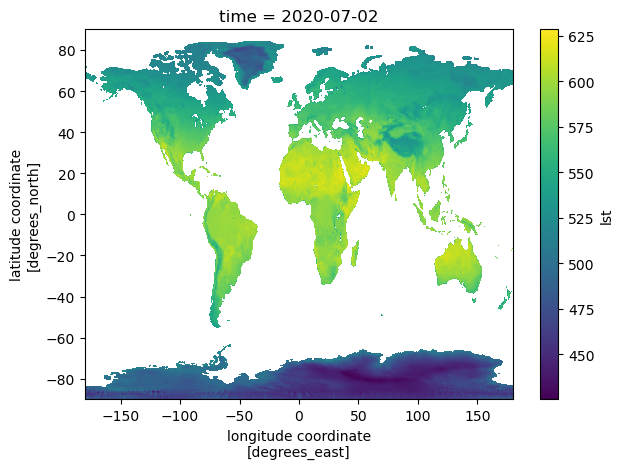

In [14]:
%%time
ds_processed.squeeze().lst.plot.imshow()